In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk

nltk.download('punkt')
nltk.download('gutenberg')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Drogias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Drogias\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [2]:
from src.spell_correction import BigramSpellCorrector, TrigramSpellCorrector
from src.autocomplete import BigramModel, START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, TrigramModel, BaseNgramModel

In [3]:
gutenberg_corpus = nltk.corpus.gutenberg.fileids()                                 #Get all the files
gutenberg_corpus

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [4]:
combined_text = ""             
for file_id in gutenberg_corpus:                                        # Combine the text from all files
    combined_text += nltk.corpus.gutenberg.raw(file_id)

print(combined_text[:500])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


In [5]:
combined_text = combined_text.lower()                              #Convert to lowercase

In [6]:
combined_text[:500]

"[emma by jane austen 1816]\n\nvolume i\n\nchapter i\n\n\nemma woodhouse, handsome, clever, and rich, with a comfortable home\nand happy disposition, seemed to unite some of the best blessings\nof existence; and had lived nearly twenty-one years in the world\nwith very little to distress or vex her.\n\nshe was the youngest of the two daughters of a most affectionate,\nindulgent father; and had, in consequence of her sister's marriage,\nbeen mistress of his house from a very early period.  her mother\nhad died t"

In [7]:
import re

def remove_special_chars(text):
   text = text.replace('[', '')
   text = text.replace(']', '')
   text = text.replace('\n', ' ')
   text = re.sub(r'[^a-zA-z.?!\']', ' ', text)                     #Remove these characters   

   return text

In [8]:
combined_text = remove_special_chars(combined_text)
combined_text[:500]

"emma by jane austen       volume i  chapter i   emma woodhouse  handsome  clever  and rich  with a comfortable home and happy disposition  seemed to unite some of the best blessings of existence  and had lived nearly twenty one years in the world with very little to distress or vex her.  she was the youngest of the two daughters of a most affectionate  indulgent father  and had  in consequence of her sister's marriage  been mistress of his house from a very early period.  her mother had died too"

In [9]:
len(combined_text.split())                     

2119883

In [10]:
len(combined_text)                             # How many characters

11793056

In [11]:
combined_text[11792000:]

"n the sea  the universe  the stars there in the     heavens   urging slowly  surely forward  forming endless  and waiting ever more  forever more behind.       good bye my fancy!  good bye my fancy! farewell dear mate  dear love! i'm going away  i know not where  or to what fortune  or whether i may ever see you again  so good bye my fancy.  now for my last  let me look back a moment  the slower fainter ticking of the clock is in me  exit  nightfall  and soon the heart thud stopping.  long have we lived  joy'd  caress'd together  delightful!  now separation  good bye my fancy.  yet let me not be too hasty  long indeed have we lived  slept  filter'd  become really blended     into one  then if we die we die together   yes  we'll remain one   if we go anywhere we'll go together to meet what happens  may be we'll be better off and blither  and learn something  may be it is yourself now really ushering me to the true songs   who     knows?  may be it is you the mortal knob really undoing 

In [12]:
def tokenize_sentences(text):
    sentences = nltk.sent_tokenize(''.join(text))                  #Get the sentences
    return sentences     

In [13]:
sentences = tokenize_sentences(combined_text) 
print(len(sentences))    
print(sentences[2])  
print(sentences[57649])

96282
her mother had died too long ago for her to have more than an indistinct remembrance of her caresses  and her place had been supplied by an excellent woman as governess  who had fallen little short of a mother in affection.
i hardly understand you   replied the scientist  with a cold intensity of manner.


In [14]:
def tokenize_words(text):
    words = nltk.word_tokenize(text)
    return words

In [15]:
words = tokenize_words(combined_text)
print(len(words))
print(words[3])
print(words[-2])

2235498
austen
fancy


In [16]:
words_list = []                                    #list of all the words of sentences
for f in sentences:
    words_list.append(tokenize_words(f))                   

In [17]:
len(words_list)

96282

In [18]:
for word in words_list[1]:                     # all the words of the second sentence
    print(word) 

she
was
the
youngest
of
the
two
daughters
of
a
most
affectionate
indulgent
father
and
had
in
consequence
of
her
sister
's
marriage
been
mistress
of
his
house
from
a
very
early
period
.


In [19]:
import random
import math


random.shuffle(words_list)
train_len = math.floor(0.6 * len(words_list))                      #Training set length(60%)
dev_len = math.floor(0.2 * len(words_list))                        #Development set length (20%)
test_len = math.floor(0.2 * len(words_list))                       #Test set length (20%)

training_set = []
development_set = []
test_set = []

for content in words_list[0:train_len]:
    training_set.append(content)
    
for content in words_list[train_len: train_len + dev_len]:
    development_set.append(content)

for content in words_list[train_len + dev_len:]:
    test_set.append(content)

In [20]:
import itertools
from collections import Counter

from nltk.util import ngrams


def _calc_ngrams(all_corpus: list[str], ngram: int) -> Counter:
    """
    Process a tokenized sentence into a list of ngrams.
    :param all_corpus: a list of all the corpus words
    :param ngram: whether the ngrams will be unigrams, bigrams etc
    :return: the counter of either unigram, bigram or trigram
    """
    unigram_counter = Counter()
    bigram_counter = Counter()
    trigram_counter = Counter()
     
    

    if ngram == 1 :
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             unigram_counter.update(grams)
        return unigram_counter
        
    elif ngram == 2:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             bigram_counter.update(grams)
        return bigram_counter
        
    elif ngram == 3:
        for sentence in all_corpus:
             grams = [gram for gram in ngrams(sentence, ngram, pad_left=True, pad_right=True,
                                    left_pad_symbol=START_TOKEN, right_pad_symbol=END_TOKEN)]
             trigram_counter.update(grams)
        return trigram_counter
        
    return 0

In [21]:
def replace_OOV_words_train(all_corpus):
    unigram_counter = _calc_ngrams(all_corpus,1)
    OOV_words = {}

    for k, v in unigram_counter.items():
        if v < 10:
            key = k[0]
            # README: Use the symbol UNKOWN_TOKEN else the model will think it's a word
            OOV_words[key] = UNKNOWN_TOKEN                 #set the word to "UNK"

    replaced_corpus = []                          #the original corpus having the OOV words replaced by 'UNK'
    for sentence in all_corpus:
        clean_sentence = []
    
        for word in sentence:
            clean_sentence.append(OOV_words.get(word, word))
    
        replaced_corpus.append(clean_sentence)


    vocabulary = []

    for key in unigram_counter.keys():        #Iterate the unigram counter
        word = key[0]                         #get the word
        if word not in OOV_words:
            vocabulary.append(word)

    vocabulary = set(vocabulary)              #Keep unique words
    return vocabulary, replaced_corpus, OOV_words

In [22]:
vocabulary, train_corpus, OOV_words = replace_OOV_words_train(training_set)

In [23]:
def replace_OOV_words_test(all_corpus, vocabulary, oov_words):
    
    replaced_corpus = []
    for sentence in all_corpus:
        updated_sent = []

        for word in sentence:
            if (word not in vocabulary) or (word in oov_words):
                updated_sent.append(UNKNOWN_TOKEN)
            else:
                updated_sent.append(word)
                
    replaced_corpus.append(updated_sent)
    return replaced_corpus   

In [24]:
development_set = replace_OOV_words_test(development_set, vocabulary, OOV_words)
test_set = replace_OOV_words_test(test_set, vocabulary, OOV_words)

In [25]:
vocab_len = len(vocabulary)
print ("Vocabulary length: ", vocab_len)

print("Unigram's 20 most common words:")
unigram_top_20 = _calc_ngrams(train_corpus, 1).most_common(20)
for gram in unigram_top_20:
    print(gram)

print("\n")
print("Bigram's 20 most common words:")
bigram_top_20 = _calc_ngrams(train_corpus,2).most_common(20)
for gram in bigram_top_20:
    print(gram)


print("\n")
print("Trigram's 20 most common words:")
trigram_top_20 = _calc_ngrams(train_corpus,3).most_common(20)
for gram in trigram_top_20:
    print(gram)

Vocabulary length:  7377
Unigram's 20 most common words:
(('the',), 80681)
(('<UNK>',), 67852)
(('and',), 57181)
(('.',), 46272)
(('of',), 42852)
(('to',), 28725)
(('a',), 20159)
(('in',), 20120)
(('i',), 18219)
(('that',), 17258)
(('he',), 15456)
(('it',), 13237)
(('his',), 12829)
(('for',), 11628)
(('was',), 11323)
(('not',), 10906)
(('with',), 10593)
(('is',), 9958)
(('you',), 9731)
(('be',), 9613)


Bigram's 20 most common words:
(('.', '<end>'), 46022)
(('of', 'the'), 11586)
(('the', '<UNK>'), 8183)
(('<start>', 'and'), 8024)
(('<UNK>', 'and'), 6372)
(('in', 'the'), 6178)
(('?', '<end>'), 6138)
(('and', 'the'), 5427)
(('<UNK>', '<UNK>'), 5277)
(('!', '<end>'), 5014)
(('<UNK>', '.'), 4906)
(('and', '<UNK>'), 4697)
(('<UNK>', 'of'), 4202)
(('the', 'lord'), 4199)
(('<start>', 'i'), 3431)
(('of', '<UNK>'), 3354)
(('to', 'the'), 3274)
(('<UNK>', 'the'), 3135)
(('<start>', 'the'), 3071)
(('a', '<UNK>'), 2472)


Trigram's 20 most common words:
(('.', '<end>', '<end>'), 46022)
(('<start>'

(ii). First step: Tune α (alpha)

##  Calculate bi-gram probability

### $ P(w_2|w_1) = \frac{C(w_1,w_2) + \alpha}{C(w_1) + \alpha \cdot|V|} $

* $ C(w_1,w_2) $ : bigram count
* $ C(w_1) $ : unigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

## Bi-gram LM Cross entropy & perplexity

* $ CrossEntropy = -\frac{1}{N}\sum^{bigrams}{log_2(P(w_2|w_1))} $
 * N: Number of bigrams
* $ Perplexity = 2^{H(p)} $

## Tri-gram LM Cross entropy & perplexity

### $ P(w_3|w_1,w_2) = \frac{C(w_1,w_2,w_3) + \alpha}{C(w_1,w_2) + \alpha \cdot |V|} $

* $ C(w_1,w_2,w_3) $ : trigram count
* $ C(w_1,w_2) $ : bigram count
* $ 0 \leq\alpha \leq1 $ :  smoothing hyper-parameter
* |V|: vocabulary size

In [26]:
def cross_entropy(model: BaseNgramModel, dataset: list[list[str]]) -> float:
    """
    Calculate the cross-entropy of a language model on a given dataset.
    
    Cross-entropy measures how well the language model predicts the given dataset.
    Lower cross-entropy indicates better model performance.
    
    :param model: The n-gram language model for which cross-entropy is calculated.
    :param dataset: The dataset as a list of tokenized sentences, where each sentence is a list of strings.
    :return: The cross-entropy score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    # since la place smoothing is only involved during inference
    # we don't need to refit the model
    sum_prob = 0
    word_count = 0
    
    for sentence in dataset:       
        # since this is a full sentence we manually append the end token
        sentence += [END_TOKEN]
        
        # take into account only the END_TOKEN since START token probs are not computed
        word_count += len(sentence)
        
        # get sentence probability
        sum_prob += bi_model.sentence_proba(sentence) 
    
    # do we need to logarithmize this again?
    return - sum_prob / word_count


def perplexity(cross_entropy: float) -> float:
    """
    Calculate perplexity from cross-entropy.
    
    Perplexity is a measure of how well the language model predicts the given dataset.
    A model with a perplexity of k, has approximately a 1/k chance of correctly predicting the next word in a sentence.
    
    :param cross_entropy: The cross-entropy score calculated for a language model on a dataset.
    :return: The perplexity score as a float.
             Lower values indicate better performance in predicting the dataset.
    """
    return 2**cross_entropy

In [27]:
def plot_alpha_vs_entropy(alpha_values, entropy, best_index):
    plt.figure(figsize=(10, 6))
    plt.plot(alpha_values, entropy, marker='o', linestyle='-', color='b')
    plt.title('Alpha vs Entropy')
    plt.xlabel('Alpha Values')
    plt.ylabel('Cross Entropy')
    plt.grid(True)
    
    # Highlight the best alpha value
    plt.scatter(alpha_values[best_index], entropy[best_index], color='r', marker='x', label='Best Alpha')
    
    plt.legend()
    plt.show()


In [28]:
def ngram_model_alpha_search(fitted_model: BaseNgramModel, 
                             alpha_values: np.ndarray, 
                             validation_dataset: list[list[str]]) -> float:
    entropy_arr = np.full_like(alpha_values, np.inf)
    
    for i in range(len(alpha_values)):
        fitted_model.alpha = alpha_values[i]
        entropy_arr[i] = cross_entropy(fitted_model, validation_dataset)
        
       
    best_index = np.argmin(entropy_arr)
    plot_alpha_vs_entropy(alpha_values,entropy_arr, best_index) 
    return alpha_values[best_index]

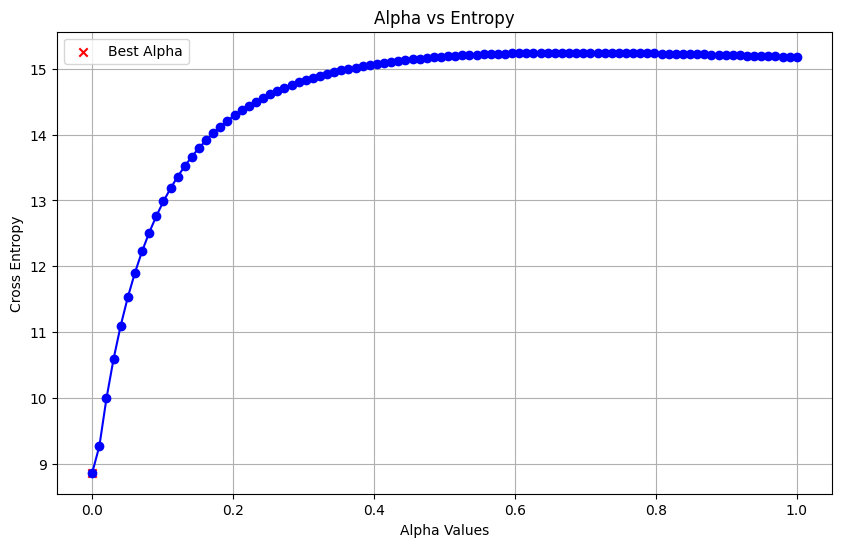

Optimal alpha (bigram model):  0.0001


In [30]:
bi_model = BigramModel(alpha=0.001)
bi_model.fit(train_corpus)

bi_opt_alpha = ngram_model_alpha_search(bi_model, np.linspace(0.0001, 1, 100), development_set)
print("Optimal alpha (bigram model): ", bi_opt_alpha)

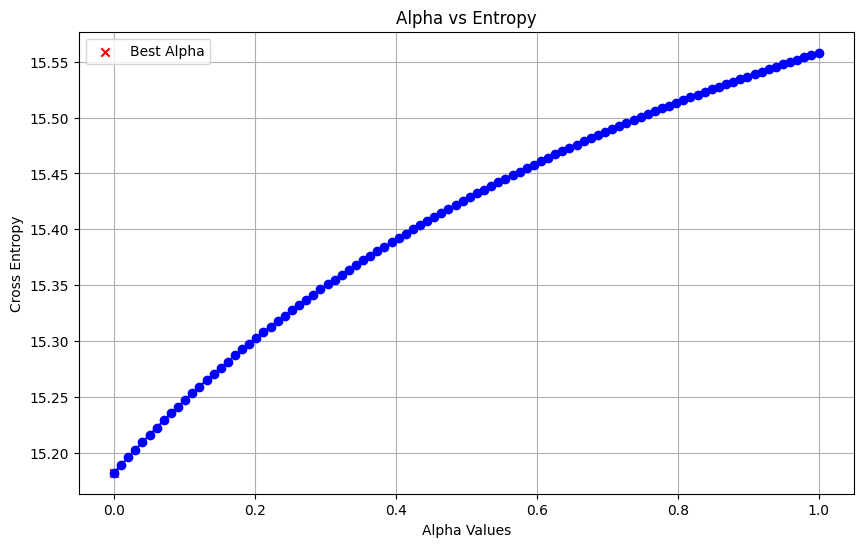

Optimal alpha (trigram model):  0.0001


In [31]:
tri_model = TrigramModel(alpha=0.001)
tri_model.fit(train_corpus)

tri_opt_alpha = ngram_model_alpha_search(tri_model, np.linspace(0.0001, 1, 100), development_set)
print("Optimal alpha (trigram model): ", tri_opt_alpha)

In [32]:
bi_model = BigramModel(alpha = bi_opt_alpha)
bi_model.fit(train_corpus)

bi_hc = cross_entropy(bi_model, train_corpus)
print("Bi-gram model Cross Entropy: ", bi_hc)
print("Bi-gram model Perplexity: ", perplexity(bi_hc))

Bi-gram model Cross Entropy:  6.170078937070566
Bi-gram model Perplexity:  72.00768281323423


In [33]:
tri_model = TrigramModel(alpha = tri_opt_alpha)
tri_model.fit(train_corpus)

tri_hc = cross_entropy(tri_model, train_corpus)
print("Tri-gram model Cross Entropy: ", tri_hc)
print("Tri-gram model Perplexity: ", perplexity(tri_hc))

Tri-gram model Cross Entropy:  7.07937207403061
Tri-gram model Perplexity:  135.23943407715737


Now, let's test the performance in the test set, after having defined the optimal alpha.

In [34]:
# since la place smoothing is only involved during inference
# we don't need to refit the model
bi_model.alpha = bi_opt_alpha

bi_hc = cross_entropy(bi_model, test_set)
print(f"Bi-gram model Cross Entropy: {bi_hc:.2f}", )
print(f"Bi-gram model Perplexity: {perplexity(bi_hc):2f}")

Bi-gram model Cross Entropy: 9.87
Bi-gram model Perplexity: 933.541601


In [35]:
tri_model.alpha = tri_opt_alpha

tri_hc = cross_entropy(tri_model, test_set)
print(f"Tri-gram model Cross Entropy: {tri_hc:.2f}")
print(f"Tri-gram model Perplexity: {perplexity(tri_hc):.2f}")

Tri-gram model Cross Entropy: 10.88
Tri-gram model Perplexity: 1883.45


In [36]:
max_depth = 5
beam_width = 3

v. Create a fake dataset

In [38]:
from nltk.tokenize import sent_tokenize
UNK_sentences = [sent_tokenize(' '.join(sentence)) for sentence in train_corpus]       #get the sentences that include UNK values

In [39]:
import random

def corrupt_sentence(sentence, probability):
    corrupted_sentence = ""
    for char in sentence:
        if char != ' ' and random.random() < probability:
            
            corrupted_sentence += get_similar_char(char)                 #replace with a similar character
        else:
            corrupted_sentence += char
    return corrupted_sentence

def get_similar_char(char):
    
    # later on maybe use the nlpaug library here 
    similar_chars = {
        'a': 'e',
        'b': 'p',
        'c': 's',
        'd': 'b',
        'e': 'a',
        'f': 't',
        'g': 'j',
        'h': 'n',
        'i': 'l',
        'j': 'g',
        'k': 'x',
        'l': 'i',
        'm': 'n',
        'n': 'm',
        'o': 'u',
        'p': 'b',
        'q': 'g',
        'r': 't',
        's': 'c',
        't': 'f',
        'u': 'o',
        'v': 'w',
        'w': 'v',
        'x': 'k',
        'y': 'v',
        'z': 's',
    }

    
    return similar_chars.get(char, char)                            #return a randomly chosen character

'''
test_corpus = ["he plays football",
               "he plais footbal",
               "she enjoys good football",
               "she plays good music",
               "he prays to god",
               "please buy me the other ball",
               "he pleases the other players by playing good football",
               "he plys god ftball"]

'''
probability = 0.2                                        #probability of character replacement


     
corrupted_corpus = [[corrupt_sentence(word, probability) for word in sentence] for sentence in UNK_sentences[1:50]]   #generate the corrupted corpus

for original, corrupted in zip(UNK_sentences[1:50], corrupted_corpus):
    print(f"Original: {original}")
    print(f"Corrupted: {corrupted}")
    print("\n---\n")


Original: ['and the lord said unto joshua this day have i rolled away the reproach of egypt from off you .', '<end> <end>']
Corrupted: ['and the iotd ceid unfo joshua this bav hawa i tollad awey the reproesn of egypf trom off yoo .', '<emd> <emb>']

---

Original: ['then i entered the hotel and coming round the other side of him saw his face in the sunlight .', '<end> <end>']
Corrupted: ['then i enfered tha hofel end conimj round tne otnet cide of hin sew nis faca in the sunlijht .', '<end> <enb>']

---

Original: ['and for an unclean person they shall take of the ashes of the burnt heifer of <UNK> for sin and running water shall be put thereto in a vessel and a clean person shall take <UNK> and dip it in the water and sprinkle it upon the tent and upon all the vessels and upon the persons that were there and upon him that touched a bone or one slain or one dead or a grave and the clean person shall sprinkle upon the unclean on the third day and on the seventh day and on the seventh da

In [40]:
from nltk.tokenize import TweetTokenizer


tweet_wt = TweetTokenizer()
tokenized = [tweet_wt.tokenize(' '.join(sentence)) for sentence in UNK_sentences[:50]]  # Get the first 50 sentences

model = BigramModel(alpha=0.01)
model.fit(tokenized)                                # model is fitted with the correct and tokenized words

corrupted_tokenized = [tweet_wt.tokenize(sentence) for sentence_list in corrupted_corpus for sentence in sentence_list] #tokenize the corrupted sentences

In [41]:
corrected = []
corrector = BigramSpellCorrector(model, lamda1=0.5, lamda2=-0.5)
for sent in corrupted_tokenized:
  output_seq = corrector.spell_correct(original_tokenized_sentence=sent, max_depth = 20, beam_width = 3)  #give the corrupt sentences to spell correct
  corrected.append(output_seq)
    
print('Original sentences:', UNK_sentences[6:11])
print('\n')
print('Corrupted(wrong) sentences:', corrupted_corpus[5:10])
print('\n')
print('Final result (corrected sentences):', corrected[5:10])

Original sentences: [['that is he spoke with <UNK> and <UNK> rapidity but with no <UNK> and therefore with no emotion .', '<end> <end>'], ['a <UNK> shall not enter into the congregation of the lord even to his tenth generation shall he not enter into the congregation of the lord .', '<end> <end>'], ['that he is <UNK> by you replied willoughby is certainly in his favour but as for the esteem of the others it is a reproach in itself .', '<end> <end>'], ['he shall judge the poor of the people he shall save the children of the needy and shall break in pieces the <UNK> .', '<end> <end>'], ['others gathered round and joined them weeping .', '<end> <end>']]


Corrupted(wrong) sentences: [['that ls ne spoke vifh <UNK> and <UNK> rapiditv put wlfh nu <UNK> end therefore wlth no emotiun .', '<emd> <end>'], ['a <UNK> shell not enter lntu the congregafiom of fhe lurd avan to his fenth generation chall ha mot emter lnto the songregefiun ot the lorb .', '<end> <end>'], ['thaf na ls <UNK> by vuo tepli

In [43]:
# You need to give incomplete sentence for autocorrect. Right now it just predicts the end of the sentences after the '.'
# Try a while loop until END_TOKEN is the output maybe

#Check how the auto correction works
predicted = []
for sent in tokenized[:3]:
    print("Original sentence", sent)
    for i, token in enumerate(sent):                     #try all possible combinations within the sentence
        partial_sent = sent[:i+1]
        if END_TOKEN in partial_sent:
            break
        pred = model.predict(tokenized_sentence = partial_sent)
        print("Original sentence: ", partial_sent)
        print("Prediction: ", pred)
        predicted.append(pred)
        print("\n")

Original sentence ['is', 'mr', '.', 'willoughby', 'much', 'known', 'in', 'your', 'part', 'of', '<UNK>', '?', '<end>', '<end>']
Original sentence:  ['is']
Prediction:  certainly


Original sentence:  ['is', 'mr']
Prediction:  .


Original sentence:  ['is', 'mr', '.']
Prediction:  <end>


Original sentence:  ['is', 'mr', '.', 'willoughby']
Prediction:  much


Original sentence:  ['is', 'mr', '.', 'willoughby', 'much']
Prediction:  known


Original sentence:  ['is', 'mr', '.', 'willoughby', 'much', 'known']
Prediction:  in


Original sentence:  ['is', 'mr', '.', 'willoughby', 'much', 'known', 'in']
Prediction:  itself


Original sentence:  ['is', 'mr', '.', 'willoughby', 'much', 'known', 'in', 'your']
Prediction:  brother


Original sentence:  ['is', 'mr', '.', 'willoughby', 'much', 'known', 'in', 'your', 'part']
Prediction:  beleeue


Original sentence:  ['is', 'mr', '.', 'willoughby', 'much', 'known', 'in', 'your', 'part', 'of']
Prediction:  shechem


Original sentence:  ['is', 'mr', '.

In [44]:
from jiwer import cer, wer


count = 0
sum_cer = 0
sum_wer = 0

In [45]:
for corrected_sentence in corrected:
    for i in range(len(corrected_sentence)):
        token_k = START_TOKEN if i == 0 else tokenized[i][i - 1]
        token_j = corrected_sentence[i]
        sum_cer += cer(token_k, token_j)
        sum_wer += wer(token_k, token_j)
        count += 1
        
avg_cer = sum_cer/count
avg_wer = sum_wer/count

print(f'Avg cer = {avg_cer}')
print(f'Avg wer = {avg_wer}')

IndexError: list index out of range